In [6]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
import os
import json
import re

# Awards

In [7]:
def scrap_awards_movie(metacriticID):
    url = 'https://www.imdb.com/title/{}/awards/'.format(metacriticID)    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) \
        AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'
    }

    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, "html.parser")

    div = soup.find_all('div', attrs={'data-testid':"awards-signpost"})
    if len(div) == 0:
        return 0, 0
    awards = div[0].find_all('div', class_="ipc-signpost__text")[0].get_text(strip=True)
    # extract the number of awards
    # Structure of the text: "N wins & M nominations."
    wins = 0
    nominations = 0
    if len(awards.split('&')) == 2:
        wins = int(awards.split('&')[0].split()[0])
        nominations = int(awards.split('&')[1].split()[0])
    elif "wins" in awards:
        wins = int(awards.split()[0])
    elif "nominations" in awards:
        nominations = int(awards.split()[0])
    return wins, nominations




In [8]:
def scrap_awards(movies_df, save_step=250):
    if not os.path.exists("data/scrap/imdb_awards.csv"):
        imdb_awards = pd.DataFrame(columns=["freebase_id", "nominations", "wins"])
    else:
        imdb_awards = pd.read_csv("data/scrap/imdb_awards.csv")

    already_scraped_movies_ids = imdb_awards["freebase_id"].unique()

    # filter movies that have already been scraped
    movies_df = movies_df.loc[~movies_df["freebase_id"].isin(already_scraped_movies_ids)].reset_index(drop=True)
    
    initial_len = len(imdb_awards)

    for i, row in tqdm(movies_df.iterrows(), total=len(movies_df)):
        imdb_id = row["imdb_id"]
        if not imdb_id:
            print(row)
            continue

        wins, nominations = scrap_awards_movie(imdb_id)

        award = pd.DataFrame({"freebase_id": [row["freebase_id"]], "nominations": [nominations], "wins": [wins]})

        imdb_awards = pd.concat([imdb_awards, award], ignore_index=True)
        if i % save_step == 0:
            imdb_awards.to_csv("data/scrap/imdb_awards.csv", index=False)
            print("Saved {} new awards".format(len(imdb_awards) - initial_len))
            initial_len = len(imdb_awards)

    imdb_awards.to_csv("data/scrap/imdb_awards.csv", index=False)

In [9]:
# Splitting cmu_movies into 4 parts
movies = pd.read_csv("data/cmu_movies.csv", sep="\t")

movies1 = movies.iloc[:int(len(movies)/4)]
movies2 = movies.iloc[int(len(movies)/4):int(len(movies)/2)]
movies3 = movies.iloc[int(len(movies)/2):int(3*len(movies)/4)]
movies4 = movies.iloc[int(3*len(movies)/4):]

movies1.to_csv("data/cmu_movies1.csv", sep="\t", index=False)
movies2.to_csv("data/cmu_movies2.csv", sep="\t", index=False)
movies3.to_csv("data/cmu_movies3.csv", sep="\t", index=False)
movies4.to_csv("data/cmu_movies4.csv", sep="\t", index=False)

In [10]:
movies = pd.read_csv("data/cmu_movies4.csv", sep="\t")
movies = movies.loc[(movies['freebase_id'].notnull()) & (movies['imdb_id'].notnull()) & (movies['metacritic_id'].notnull())] 
scrap_awards(movies, save_step=25)

  0%|          | 0/2164 [00:00<?, ?it/s]

Saved 1 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
Saved 25 new awards
S

In [11]:
# Concatenating the 4 parts
db_paths = ["data/scrap/imdb_awards1.csv", "data/scrap/imdb_awards2.csv", "data/scrap/imdb_awards3.csv", "data/scrap/imdb_awards4.csv"]
df = pd.concat([pd.read_csv(path) for path in db_paths], ignore_index=True)
df.to_csv("data/scrap/imdb_awards.csv", index=False)

Text(0.5, 1.0, 'Distribution of the number of awards')

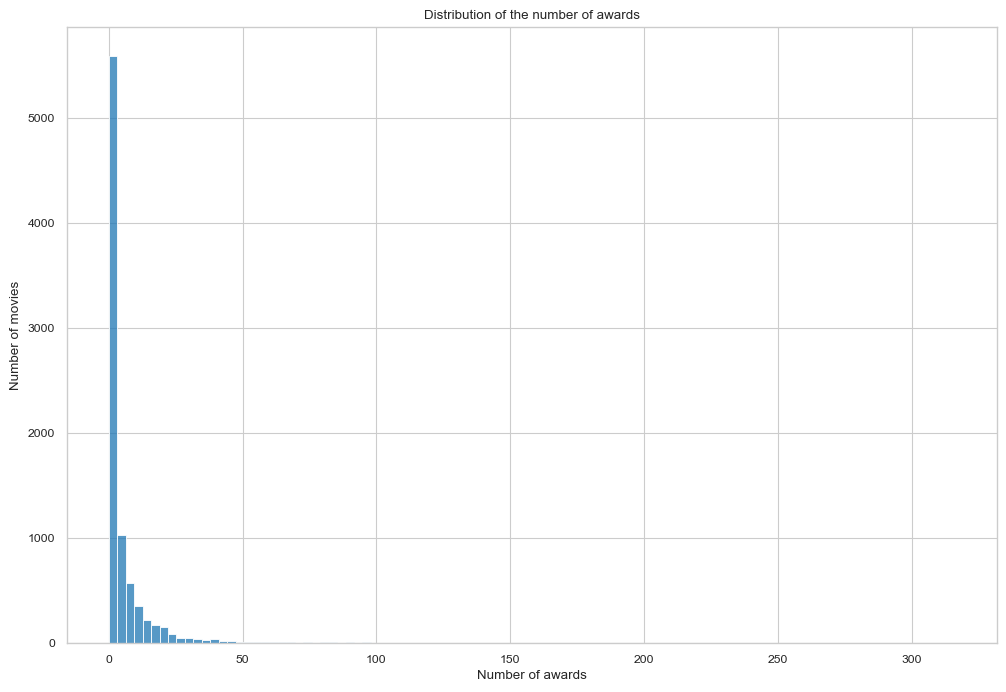

In [13]:
# Plot the distribution of the number of awards
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")
plt.figure(figsize=(12, 8))
sns.histplot(df["wins"], bins=100)
plt.xlabel("Number of awards")
plt.ylabel("Number of movies")
plt.title("Distribution of the number of awards")

In [14]:
df.describe(include="all")

,freebase_id,nominations,wins
count,8543,8543.000000,8543.000000
unique,8543,NaN,NaN
top,/m/03vyhn,NaN,NaN
freq,1,NaN,NaN
mean,NaN,9.369659,5.676577
std,NaN,21.634868,13.420889
min,NaN,0.000000,0.000000
25%,NaN,0.000000,0.000000
50%,NaN,3.000000,2.000000
75%,NaN,9.000000,6.000000


In [16]:
df[df["wins"] > 100].sort_values(by="wins", ascending=False)

,freebase_id,nominations,wins
7881,/m/0358x_,806,316
5995,/m/02d3wv,233,245
7126,/m/0g5rm7s,187,240
8467,/m/017jd9,124,215
3176,/m/0gj50,575,192
4403,/m/02qzhdk,218,175
7984,/m/07s846j,186,173
382,/m/0b6tzs,139,164
4014,/m/0btpm6,164,162
1841,/m/0gmcwlb,204,162


In [ ]:
# get movie with freebase id /m/0358x_
movies = pd.read_csv("data/cmu_movies.csv", sep="\t")

movies.loc[movies["freebase_id"] == "/m/0358x_"]